# Table of contents
1. [*Import* Libraries](#libs)
2. [Some paragraph](#paragraph1)
    1. [Sub paragraph](#subparagraph1)
3. [Another paragraph](#paragraph2)

## 1. <i>Import</i> Libraries <a name = "libs"></a>"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, make_scorer
from  sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

import pickle
import eli5

__author__ = "Sid Vanam"
__email__ = "vanamsid@gmail.com"

/Users/vanamsid/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/vanamsid/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metr

## Create Helper Functions

In [2]:
def round_dict(dic):
    '''rounds the dictionary values to int values'''
    for k,v in dic.items():
        if k == 'learning_rate':
            pass
        dic[k] = round(v)
    return dic

## Import Train and Test data

In [3]:
'''Read Train Data'''
with open('../salary prediction data/Pickle Data/TRAIN_X.pkl', 'rb') as temp0:
    X_train = pickle.load(temp0)
with open('../salary prediction data/Pickle Data/TRAIN_Y.pkl', 'rb') as temp1:
    y_train = pickle.load(temp1)
    
'''Read Validation Data'''
with open('../salary prediction data/Pickle Data/VALID_X.pkl', 'rb') as temp2:
    X_valid = pickle.load(temp2)
with open('../salary prediction data/Pickle Data/VALID_Y.pkl', 'rb') as temp3:
    y_valid = pickle.load(temp3)
    
'''Read Test Data'''
with open('../salary prediction data/Pickle Data/TEST_X.pkl', 'rb') as temp4:
    X_test = pickle.load(temp4)
with open('../salary prediction data/Pickle Data/TEST_Y.pkl', 'rb') as temp5:
    y_test = pickle.load(temp5)

In [4]:
X = pd.concat([X_train, X_valid], axis= 0)
X.shape

(799996, 27)

In [5]:
y = pd.concat([y_train, y_valid], axis = 0)
y.shape

(799996,)

## Load Models

In [6]:
with open('../salary prediction data/Base Models/base_lr.pkl', 'rb') as temp0:
    base_lr = pickle.load(temp0)
with open('../salary prediction data/Base Models/base_rf.pkl', 'rb') as temp1:
    base_rf = pickle.load(temp1)
with open('../salary prediction data/Base Models/base_gbr.pkl', 'rb') as temp2:
    base_gbr = pickle.load(temp2)
with open('../salary prediction data/Base Models/base_xgbr.pkl', 'rb') as temp3:
    base_xgbr = pickle.load(temp3)

[22:35:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Tune Hyperparameters with Hyperopt library

## Random Forest

In [11]:
seed=42

In [8]:
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    
    model=RandomForestRegressor(n_estimators= est, max_depth= md, 
                                min_samples_leaf= msl, min_samples_split= mss, n_jobs = -1)
    model.fit(X_train,y_train)
    predictions= model.predict(X_valid)
    score= mean_squared_error(y_valid, predictions)
    return score

def optimize(trial):
    params={'n_estimators': hp.uniform('n_estimators',50,500),
           'max_depth': hp.uniform('max_depth',5,30),
           'min_samples_leaf': hp.uniform('min_samples_leaf',1,20),
           'min_samples_split': hp.uniform('min_samples_split',2,15)
           }
    
    best= fmin(fn= objective, space= params, algo= tpe.suggest,
              trials= trial, max_evals=100, rstate=np.random.RandomState(seed))
    return best

rf_trials = Trials()
best_rf = optimize(rf_trials)
print(best_rf)

100%|██████████| 100/100 [12:28:57<00:00, 449.37s/trial, best loss: 370.8211727768809]  
{'max_depth': 22.307401645904864, 'min_samples_leaf': 19.084895345230084, 'min_samples_split': 10.537707786140446, 'n_estimators': 397.23100705774596}


In [9]:
best_rf = round_dict(best_rf)
best_rf_model = RandomForestRegressor(**best_rf, n_jobs= -1)

## Gradient Boosting Regressor

In [12]:
def gbr_objective(params):
    lr = float(params['learning_rate'])
    est = int(params['n_estimators'])
    md = int(params['max_depth'])
    msl = int(params['min_samples_leaf'])
    
    model = GradientBoostingRegressor(learning_rate = lr, n_estimators = est,
                                      max_depth = md, min_samples_leaf = msl)
    model.fit(X_train,y_train)
    predictions = model.predict(X_valid)
    score = mean_squared_error(y_valid, predictions)
    return score

def optimize_gbr(trial):
    params= {'n_estimators': hp.uniform('n_estimators',50,500),
           'max_depth': hp.uniform('max_depth',5,20),
           'min_samples_leaf': hp.uniform('min_samples_leaf',1,15),
           'learning_rate': hp.uniform('learning_rate',0,1)
           }
    best = fmin(fn= gbr_objective, space= params, algo= tpe.suggest,
               trials = gbr_trials, max_evals= 100, rstate= np.random.RandomState(seed))
    return best
gbr_trials = Trials()
best_gbr = optimize_gbr(gbr_trials)
print(best_gbr)

100%|██████████| 100/100 [33:14:08<00:00, 1196.49s/trial, best loss: 356.7761507780902]   
{'learning_rate': 0.08784438627182596, 'max_depth': 6.390430318247735, 'min_samples_leaf': 6.7696079290589335, 'n_estimators': 362.8394734423886}


In [13]:
best_gbr = round_dict(best_gbr)
best_gbr_model = GradientBoostingRegressor(**best_gbr)

## LightGBM Regressor

In [14]:
def lgbr_objective(params):
    lr = float(params['learning_rate'])
    est = int(params['n_estimators'])
    md = int(params['max_depth'])
    min_loss = float(params['min_split_gain'])
    
    model = LGBMRegressor(learning_rate= lr, n_estimators= est, max_depth= md,
                         min_split_gain= min_loss, n_jobs= -1)
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    score = mean_squared_error(y_valid, predictions)
    return score

def optimize_lgbr(trial):
    params = {'learning_rate': hp.uniform('learning_rate',0,1),
              'n_estimators': hp.uniform('n_estimators',50,500),
              'max_depth': hp.uniform('max_depth',5,20),
              'min_split_gain': hp.uniform('min_split_gain',0,50)
           }
    best = fmin(fn = lgbr_objective, space = params, algo = tpe.suggest,
                trials = lgbr_trials, max_evals = 100, rstate = np.random.RandomState(seed))
    
    return best

lgbr_trials = Trials()
best_lgbr = optimize_lgbr(lgbr_trials)
print(best_lgbr)

100%|██████████| 100/100 [15:09<00:00,  9.10s/trial, best loss: 356.424364512375] 
{'learning_rate': 0.0639840702751215, 'max_depth': 9.427637735168476, 'min_split_gain': 11.849773227982057, 'n_estimators': 436.0472929446729}


In [15]:
best_lgbr = round_dict(best_lgbr)
best_lgbr_model = LGBMRegressor(**best_lgbr, n_jobs= -1)

## XGBoost Regressor

In [16]:
def xgbr_objective(params):
    lr = float(params['learning_rate'])
    est = int(params['n_estimators'])
    md = int(params['max_depth'])
    min_loss = float(params['gamma'])
#     depth_choice = str(params['depthwise'])
    
    model = XGBRegressor(learning_rate= lr, n_estimators= est, max_depth= md,
                         gamma= min_loss, n_jobs= -1)
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    score = mean_squared_error(y_valid, predictions)
    return score

def optimize_xgbr(trial):
    params = {'learning_rate': hp.uniform('learning_rate',0,1),
              'n_estimators': hp.uniform('n_estimators',50,500),
              'max_depth': hp.uniform('max_depth',5,20),
              'gamma': hp.uniform('gamma',0,50)
           }
    best = fmin(fn = xgbr_objective, space = params, algo = tpe.suggest,
                trials = xgbr_trials, max_evals = 100, rstate = np.random.RandomState(seed))
    
    return best

xgbr_trials = Trials()
best_xgbr = optimize_xgbr(xgbr_trials)
print(best_xgbr)

[18:17:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:33:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:27:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[05:42:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [19]:
best_xgbr = round_dict(best_xgbr)
best_xgbr_model = XGBRegressor(**best_xgbr, n_jobs = -1)

## Comparing Losses of Tuned Models

In [86]:
with open('../salary prediction data/initial_scores.pkl', 'rb') as scores:
    initial_scores = pickle.load(scores)

In [103]:
bases = pd.DataFrame(initial_scores)
bases.index.name = 'Models'
bases = bases.rename(columns = {0: 'Base MSE Score'})
bases['Tuned MSE Scores'] = 0

,Base MSE Score,Tuned MSE Scores
Models,,
RandomForestRegressor,470.919339,0
XGBRegressor,395.182845,0
LinearRegression,384.618384,0
LightGBMRegressor,372.049423,0
GradientBoostingRegressor,362.088588,0


In [74]:
model_names = ['LinearRegression', 'RandomForestRegressor', 
               'GradientBoostingRegressor', 'LightGBMRegressor', 'XGBRegressor']

In [82]:
trial_losses = [round(trial.best_trial['result']['loss'], 2) for trial in trial_list]
trial_losses.insert(0,0) #inserts a 0 at index 0 for the post_linear_regression result

In [84]:
model_and_trials = dict(zip(model_names, trial_losses))

In [85]:
model_and_trials

{'LinearRegression': 0,
 'RandomForestRegressor': 370.82,
 'GradientBoostingRegressor': 356.78,
 'LightGBMRegressor': 356.42,
 'XGBRegressor': 357.51}

In [109]:
for i in bases.index:
    if i == 'LinearRegression':
        bases.loc[i, 'Tuned MSE Scores'] = bases.loc[i, 'Base MSE Score']
    else:
        bases.loc[i, 'Tuned MSE Scores'] = model_and_trials[i]
bases

,Base MSE Score,Tuned MSE Scores
Models,,
RandomForestRegressor,470.919339,370.820000
XGBRegressor,395.182845,357.510000
LinearRegression,384.618384,384.618384
LightGBMRegressor,372.049423,356.420000
GradientBoostingRegressor,362.088588,356.780000


## Summary of Tuned Models

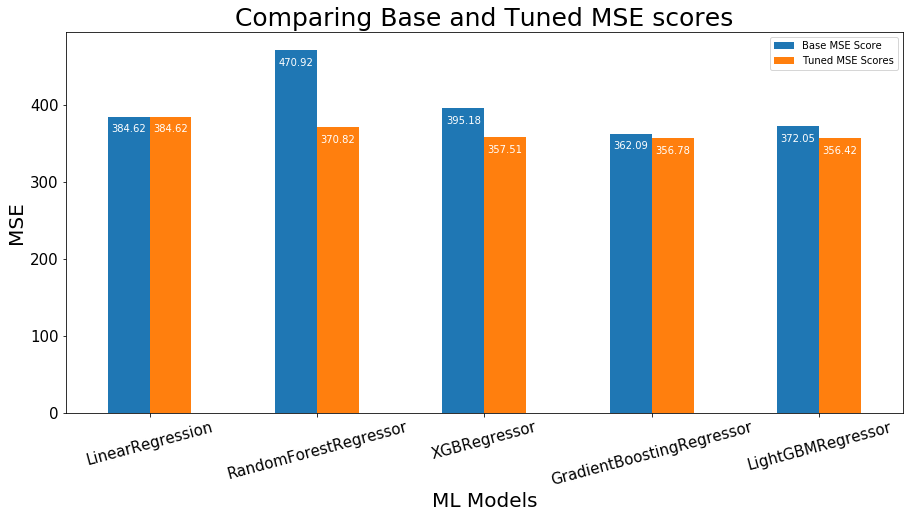

In [156]:
ax = bases.sort_values(by='Tuned MSE Scores', ascending= False).plot(kind = 'bar', figsize = (15,7))
plt.xticks(rotation = 15)
plt.title('Comparing Base and Tuned MSE scores', fontdict = {'fontsize' : 25})
plt.xlabel('ML Models', fontdict= {'fontsize' : 20})
plt.ylabel('MSE', fontdict= {'fontsize' : 20})


for i in ax.patches:
    ax.text(i.get_x()+0.02, i.get_height()-20, str(round((i.get_height()), 2)), fontsize=10, color='white')

for ticklabel in (ax.get_xticklabels()):
    ticklabel.set_fontsize(15)
for ticklabel in (ax.get_yticklabels()):
    ticklabel.set_fontsize(15)

### Summary: 
Boosting Regressors yielded the **lowest MSE** with scores of ~356
- LightGBM Regressor
- GradientBoosting Regressor

*Random Forest Regressor* led to a **greatest reduced loss** of 100 MSE